In [1]:
# Setup
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.io import loadmat
from sklearn.preprocessing import normalize
from tqdm.auto import trange, tqdm
from seaborn import set_theme
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
device = "cpu"
print(f"DEVICE: {device}")
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

plt.style.use("duarte.mplstyle")
%matplotlib widget

DEVICE: cpu


In [2]:
all_forces_mat = loadmat("../../../../tau_all.mat")
all_states_mat = loadmat("../../../../xs_all.mat")

In [3]:
all_forces_formated = all_forces_mat["tau_all"].squeeze()
pd.DataFrame(all_forces_formated).tail()

,0
995,"[[21.582000000000004, 28.842000000000006, 28.8..."
996,"[[21.582000000000004, 28.842000000000006, 28.8..."
997,"[[21.582000000000004, 28.842000000000006, 28.8..."
998,"[[21.582000000000004, 28.842000000000006, 28.8..."
999,"[[21.582000000000004, 28.842000000000006, 28.8..."


In [4]:
def preprocessing_from_matlab(dataset, n=0):
    key = list(dataset.keys())[-1]
    all_data = dataset[key].squeeze()
    all_data_preprocessed = []
    
    for data in all_data:
        all_data_preprocessed.append(data.T)

    return all_data_preprocessed

In [5]:
all_forces_preprocessed = preprocessing_from_matlab(all_forces_mat)
all_states_preprocessed = preprocessing_from_matlab(all_states_mat)

In [6]:
u1 = []
u2 = []
u3 = []
u4 = []

for forces in all_forces_preprocessed:
    u1.append(forces[:, 0])
    u2.append(forces[:, 1])
    u3.append(forces[:, 2])
    u4.append(forces[:, 3])

In [7]:
len(u1[0])

20001

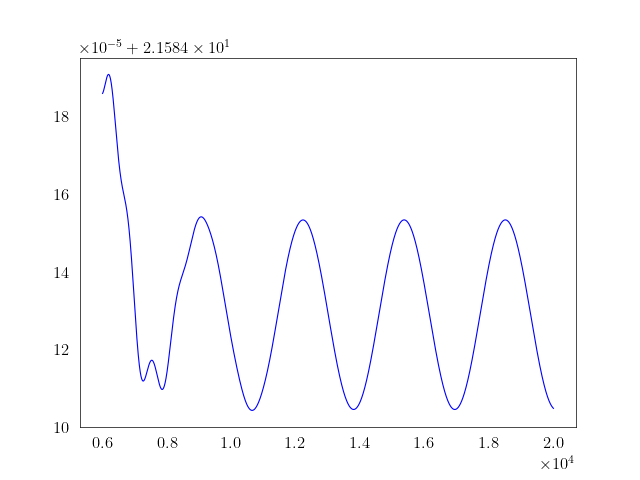

In [8]:
t = np.arange(0,len(u1[0]),1)
plt.cla()
plt.plot(t[6000:], u1[0][6000:])
plt.show()

In [9]:
all_states_preprocessed_normalized = [normalize(state, axis=0) for state in all_states_preprocessed]

In [10]:
u1[0] == u1[1]

array([ True,  True,  True, ..., False, False, False])

In [11]:
class StatesAndForces(Dataset):

    def __init__(self, states, forces):
        super().__init__()
        self.states = states
        self.forces = forces
        if len(states) == len(forces):
            self.length = len(states)
        else:
            raise ValueError("States and forces must be the same length.") 

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        force = self.forces[index]
        state = self.states[index]
        force = torch.tensor(force, dtype=torch.float32)
        state = torch.tensor(state, dtype=torch.float32)
        
        return state, force

In [12]:
dataset = StatesAndForces(all_states_preprocessed, u1)

In [13]:
train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE,
                             shuffle=True)

print(f"Lenght of train data: {len(train_dataloader)}")
print(f"Lenght of test data: {len(test_dataloader)}")

Lenght of train data: 800
Lenght of test data: 200


In [14]:
class ModelA(nn.Module):

    def __init__(self, input_layer, output_layer, hidden_layers, activation_function=nn.ReLU()):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_layer, hidden_layers),
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, output_layer)
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
INPUT_LAYER = 12
HIDDEN_LAYERS = 128
OUTPUT_LAYER = 1
ACTIVATION_FUNCTION = nn.ReLU()

model = ModelA(input_layer=INPUT_LAYER,
               hidden_layers=HIDDEN_LAYERS,
               output_layer=OUTPUT_LAYER,
               activation_function=ACTIVATION_FUNCTION).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# model.state_dict()

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        return loss

def test(dataloader, model, loss_fn):
    model.eval()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

    with torch.inference_mode():
        test_pred = model(X)
        test_loss = loss_fn(test_pred, y)

    return test_loss

In [17]:
epochs = 50
loss_overall = []
loss_overall_test = []

for epoch in trange(epochs): 
    loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.8f} | Test loss: {test_loss:.8f}")
        print("-"*50)
    loss_overall.append(loss.item())
    loss_overall_test.append(test_loss.item())
    
print("Done!")

  0%|          | 0/50 [00:00<?, ?it/s]

/home/gabriel/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 20001])) that is different to the input size (torch.Size([1, 20001, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 465.08099365 | Test loss: 464.64276123
--------------------------------------------------
Epoch: 10 | Train loss: 441.90716553 | Test loss: 431.68316650
--------------------------------------------------
Epoch: 20 | Train loss: 82.89907074 | Test loss: 111.30213165
--------------------------------------------------
Epoch: 30 | Train loss: 21.23177719 | Test loss: 21.97329903
--------------------------------------------------
Epoch: 40 | Train loss: 4.59326744 | Test loss: 15.93128014
--------------------------------------------------
Done!


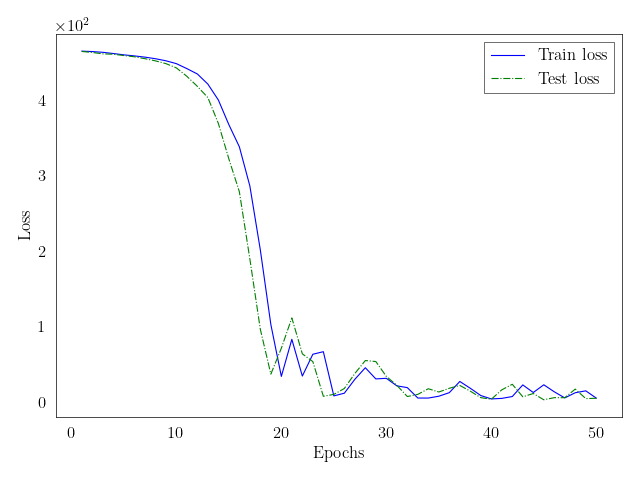

In [18]:
t = np.linspace(1, epochs, epochs)

cm=1/2.54
fig, ax = plt.subplots()

ax.plot(t, loss_overall, label='Train loss')
ax.plot(t, loss_overall_test, label='Test loss', ls="-.")
ax.set_xlabel('Epochs')
ax.set_ylabel("Loss")
ax.legend()
fig.tight_layout()


In [19]:
model.eval()

with torch.inference_mode():
    my_inference = model(test_data[150][0].to(device))

In [20]:
len(test_data[150][1])

20001

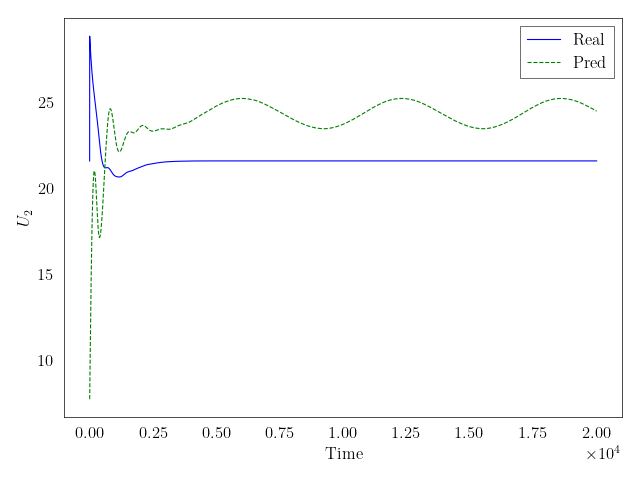

In [21]:
t = np.arange(0,len(test_data[150][1]),1)

cm=1/2.54
fig, ax = plt.subplots()

ax.plot(t, test_data[150][1], label="Real")
ax.plot(t, my_inference.to("cpu"), label="Pred")
ax.set_ylabel(f"$U_2$")
ax.set_xlabel("Time")
ax.legend(loc="best")

fig.tight_layout()